Cross-Validation Scores: [0.63636364 0.54545455 0.63636364 0.5        0.8       ]
Average CV Accuracy: 0.6236363636363637
Best Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Confusion Matrix:
 [[3 2]
 [1 6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.75      0.86      0.80         7

    accuracy                           0.75        12
   macro avg       0.75      0.73      0.73        12
weighted avg       0.75      0.75      0.74        12

Confusion Matrix:
 [[3 2]
 [1 6]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       0.75      0.86      0.80         7

    accuracy                           0.75        12
   macro avg       0.75      0.73      0.73        12
weighted avg       0.75      0.75      0.74        12


=== 

C:\Users\Rouli Elizabeth\AppData\Local\Temp\ipykernel_19636\2982546883.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')


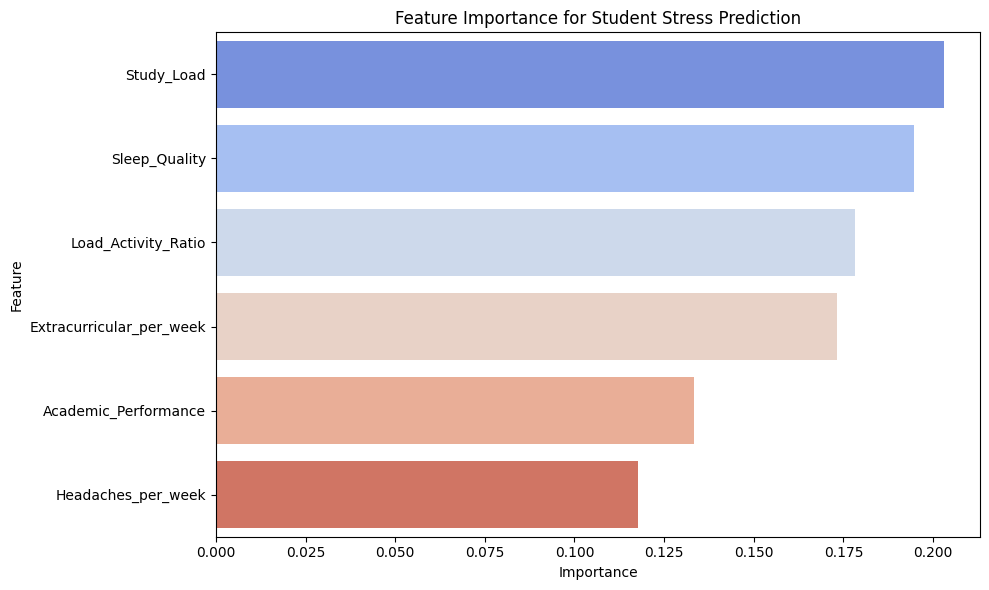


=== Descriptive Importance ===

4. Study_Load: contributes 0.2029 importance score to the model.
1. Sleep_Quality: contributes 0.1945 importance score to the model.
6. Load_Activity_Ratio: contributes 0.1781 importance score to the model.
5. Extracurricular_per_week: contributes 0.1731 importance score to the model.
3. Academic_Performance: contributes 0.1334 importance score to the model.
2. Headaches_per_week: contributes 0.1178 importance score to the model.
Logistic Regression:               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       0.62      0.71      0.67         7

    accuracy                           0.58        12
   macro avg       0.56      0.56      0.56        12
weighted avg       0.57      0.58      0.57        12

KNN:               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       0.67      0.86      0.75         7

    accuracy    

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# ==========================
# 1. LOAD DATA
# ==========================

df = pd.read_csv("Student Stress Factors.csv")

# Drop timestamp
df.drop('Timestamp', axis=1, inplace=True)

# Rename kolom agar lebih mudah dipakai (opsional)
df.columns = [
    'Sleep_Quality', 'Headaches_per_week', 'Academic_Performance',
    'Study_Load', 'Extracurricular_per_week', 'Stress_Level'
]

# ==========================
# 2. BINARIZE TARGET
# ==========================

df['Stress_Label'] = df['Stress_Level'].apply(lambda x: 0 if x <= 2 else 1)

# Drop original stress level (opsional)
df.drop('Stress_Level', axis=1, inplace=True)

# ==========================
# 2B. FEATURE ENGINEERING
# ==========================

df['Load_Activity_Ratio'] = df['Study_Load'] / (df['Extracurricular_per_week'] + 1)

# ==========================
# 3. SPLIT FEATURES & LABEL
# ==========================

X = df.drop('Stress_Label', axis=1)
y = df['Stress_Label']

# ==========================
# 4. SCALING
# ==========================

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
# 4B. CROSS-VALIDATION
# ==========================

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(RandomForestClassifier(random_state=42), X_scaled, y, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Average CV Accuracy:", cv_scores.mean())


# ==========================
# 5. HANDLE IMBALANCED DATA
# ==========================

from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_scaled, y)

# Split ulang setelah SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)


# ==========================
# 6. TRAIN MODEL
# ==========================

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ==========================
# 6B. HYPERPARAMETER TUNING
# ==========================

from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3)
grid_search.fit(X_train, y_train)

print("Best Params:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

# Gunakan best_rf sebagai model baru untuk evaluasi
y_pred = best_rf.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ==========================
# 7. EVALUASI
# ==========================

y_pred = model.predict(X_test)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ==========================
# 8. FEATURE IMPORTANCE
# ==========================

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\n=== Feature Importances ===\n")
print(importance_df)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='coolwarm')
plt.title('Feature Importance for Student Stress Prediction')
plt.tight_layout()
plt.show()

# ==========================
# 9. NARATIVE REPORT
# ==========================

print(f"\n=== Descriptive Importance ===\n")
for i, row in importance_df.iterrows():
    print(f"{i+1}. {row['Feature']}: contributes {row['Importance']:.4f} importance score to the model.")


# ==========================
# 10. ANOTHER MODEL
# ==========================
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print("Logistic Regression:", classification_report(y_test, logreg.predict(X_test)))

# KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print("KNN:", classification_report(y_test, knn.predict(X_test)))

